# Supervised Machine Learning Fundamentals

## Introduction

A Tour & Travels Company Is Offering Travel Insurance Package To Their Customers.
The Company Requires To Know The Which Customers Would Be Interested To Buy It Based On Its Database History.

The aim of this work is to analyze the dataset of the Travel Insurance and find useful insights which could help business with predicting which customer have higher or lower risk and which will take Insurance.

We will check for data quality, correlations and relation of features. We will perform statistical inference, form hypothesis base by what we find in our data and create machine learning models to predict which customer risk.

Dataset consists of 10 columns:
<li>Index - Number of row.</li>
<li>Age - Age Of The Customer</li>
<li>Employment Type - The Sector In Which Customer Is Employed</li>
<li>GraduateOrNot - Whether The Customer Is a College Graduate Or Not</li>
<li>AnnualIncome - The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]</li>
<li>FamilyMembers - Number Of Members In Customer's Family</li>
<li>ChronicDisease - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthma, etc.</li>
<li>FrequentFlyer - Derived Data Based On Customer's History Of Booking Air Tickets On At least 4 Different Instances In The Last 2 Years[2017-2019].</li>
<li>
EverTravelledAbroad - Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]</li>
<li>TravelInsurance - Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.</li>

## Notebook Preparation

In this section we will prepare our notebook by importing necessary libraries and setting up custom styles.

In [1]:
%matplotlib inline

# Third party library imports 
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import loguniform, uniform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Set up custom settings for plots
sns.set(style="whitegrid")

In [3]:
data_path = "data/TravelInsurancePrediction.csv"
df = pd.read_csv(data_path)

In [4]:
def string_to_boolen_converter(df, cols):
    """
    Convert specific columns from yes/no to boolean 1/0.

    Params:
    df (dataframe): Dataframe containing data.
    cols (list): List of columns which need to be converted.

    Return:
    df (dataframe): Dataframe with specific columns converted to boolean type.
    """

    for col in cols:
        if col in df.columns:
            df[col] = np.where(df[col].values == "Yes", 1, 0)
            df[col] = df[col].astype('int64')
        else:
            print(f"Column {col} does not exists in dataframe.")
    return df

In [5]:
def add_whitespace_before_uppercase(column_name):
    """
    Split column names if they are joined.

    Params: 
    column_name - Dataframe column name, which need to be formatted.

    Return:
    Formatted column name.
    """
    # Use regex to find uppercase letters and add a space before them
    column_name = column_name.replace(" ", "")
    return re.sub(r"(?<!^)(?=[A-Z])", " ", column_name)

## Data Cleaning

In data cleaning part we will check our data quality. We will check for any duplicate values or missing ones.

In [6]:
df.isnull().any()

Unnamed: 0             False
Age                    False
Employment Type        False
GraduateOrNot          False
AnnualIncome           False
FamilyMembers          False
ChronicDiseases        False
FrequentFlyer          False
EverTravelledAbroad    False
TravelInsurance        False
dtype: bool

In [7]:
df.duplicated().any()

False

We didn't find any missing or duplicate values. But we know we have index column which is not useful for us, we will drop this column from our data frame. 

In [8]:
df = df.drop(["Unnamed: 0"], axis=1)

In [9]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


From a brief view of data frame we see that some columns have Yes and No values, we need to check if these columns have only those types of answers, if so we will change these columns to boolean type. Also, column Employment Type can be checked and edited if needed.

In [10]:
df["GraduateOrNot"].unique()

array(['Yes', 'No'], dtype=object)

In [11]:
df["FrequentFlyer"].unique()

array(['No', 'Yes'], dtype=object)

In [12]:
df["EverTravelledAbroad"].unique()

array(['No', 'Yes'], dtype=object)

In [13]:
df["Employment Type"].unique()

array(['Government Sector', 'Private Sector/Self Employed'], dtype=object)

We see 4 columns which are strings, and they have only 2 answers. In this case, we will change 3 of them <b>GraduateOrNot</b>, <b>FrequentFlyer</b> and <b>EverTravelledAbroad</b> to int64 type. As it will be more efficient in memory and later creating ML model. For <b>Employment Type</b> column, we will leave it as it be, but we will add a column to represent 0 and 1. Government Sector	will be 1, while 0 will represent Private Sector/Self Employed.

In [14]:
df.insert(2, "EmploymentTypeBinary", None)
df["EmploymentTypeBinary"] = [1 if x == "Government Sector" else 0 for x in df["Employment Type"]]
df = df.drop(["Employment Type"], axis=1)

In [15]:
list_of_columns = ("GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad")
df = string_to_boolen_converter(df=df, cols=list_of_columns)

We can format our column names, so it will visually be nicer to look and read.

In [16]:
df.columns = [add_whitespace_before_uppercase(col) for col in df.columns]

In addition, as our Annual Income is calculated per year, it should be wise to divide it by 100 000, so our numbers will be similar to other column values.

In [17]:
df["Annual Income"] = df["Annual Income"].apply(lambda x: x//100000)
df = df.rename(columns={"Annual Income": "Annual Income (10k)"})

### Data Cleaning Summary
<li>Data don't have any duplicate or missing values in our data.</li>
<li>We change columns <b>GraduateOrNot</b>, <b>FrequentFlyer</b> and <b>EverTravelledAbroad</b> types from object to int.</li>
<li>We add additional column <b>Employment Type Binary</b> which corresponds to Employment Type but it will show numeric values.</li>
<li>Formatted column names.</li>
<li>Modify Annual Income to represent thousands.</li>

We are now ready to move forward with our data.

## Exploratory Data Analysis

We know from a dataset that it contains demographic and behavioral information about customers. Like dataset owner mentions, these customers could be from India as Annual Income is Rupees. Also, as we know we this analysis should be more about getting information which help Insurance companies to pick the best customers. 

First, let's check if our data don't have any outliers which can skew our data or show any unusual anomalies.

In [18]:
df.describe()

,Age,Employment Type Binary,Graduate Or Not,Annual Income (10k),Family Members,Chronic Diseases,Frequent Flyer,Ever Travelled Abroad,Travel Insurance
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000
mean,29.650226,0.286865,0.851535,9.164066,4.752894,0.277806,0.209864,0.191243,0.357323
std,2.913308,0.452412,0.355650,3.772383,1.609650,0.448030,0.407314,0.393379,0.479332
min,25.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,1.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1.000000,12.000000,6.000000,1.000000,0.000000,0.000000,1.000000
max,35.000000,1.000000,1.000000,18.000000,9.000000,1.000000,1.000000,1.000000,1.000000


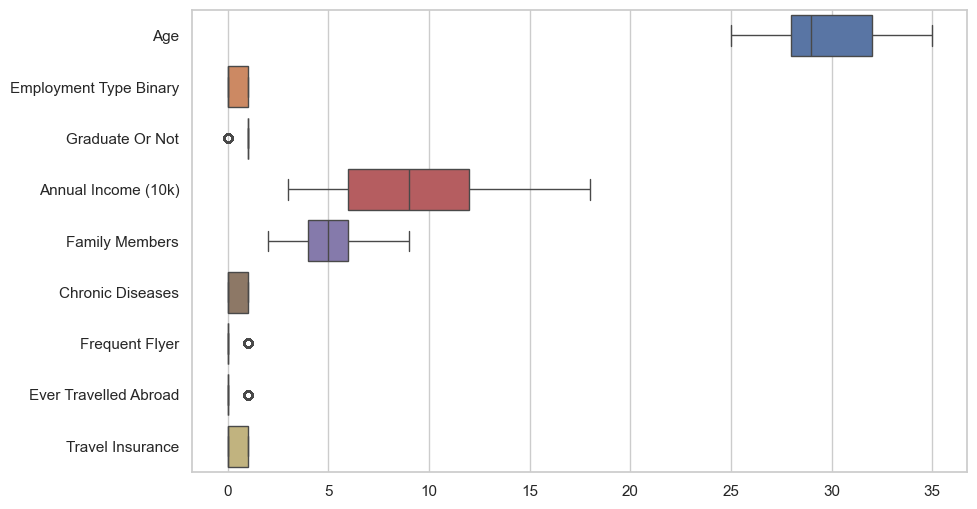

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient="h");

Checking from basic statistical view, we already can some aspects which can be analyzed further. Our data is a sample of people from age 25 till 35 while mean showing 29. 
But we also need to know that it is just a small portion of people who travel, so we already know that latter we will predict only 25–35 years old people and possible from India. 
The only information about <b>Graduation</b>, <b>Frequent Flyer</b> and <b>Ever Traveled Abroad</b> show possible outliers, but as these features consists only of 2 possible outcomes we can agree that they are not outliers.
But we will go deeper soon, for now we can see that data don't have any outliers which could indicate that data need to be, modify in any way.

Let's check the correlation between the features.

In [20]:
df.columns

Index(['Age', 'Employment Type Binary', 'Graduate Or Not',
       'Annual Income (10k)', 'Family Members', 'Chronic Diseases',
       'Frequent Flyer', 'Ever Travelled Abroad', 'Travel Insurance'],
      dtype='object')

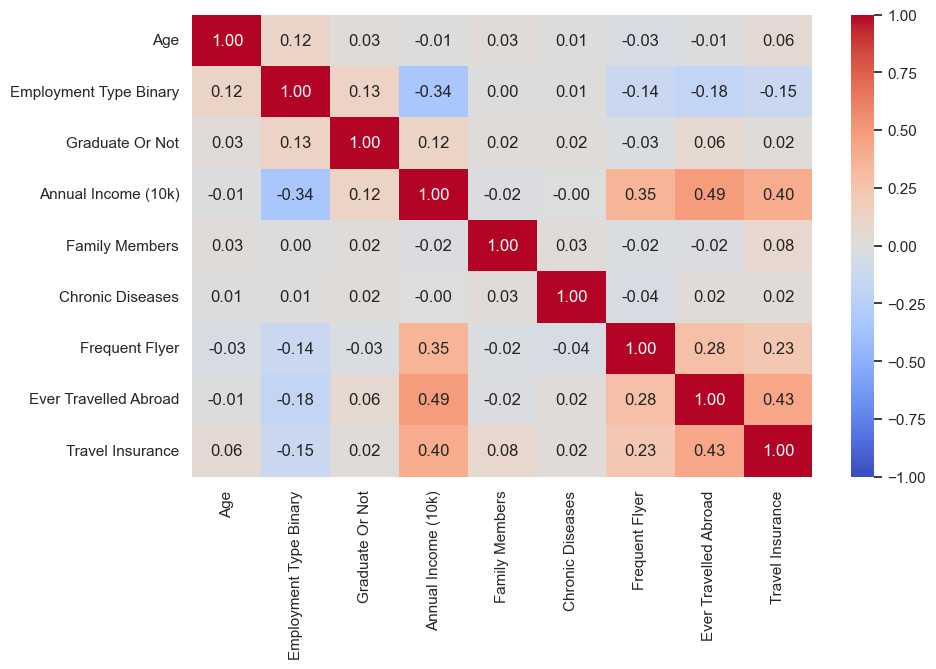

In [21]:
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f");

We can see that we have some positive and negative correlations between features.
<li>Income have negative correlation with Employment Type, which means we have big difference between Employment Type and Salary.</li>
<li>Income also have positive correlation with traveling, which is quite obvious.</li>
<li>People tend to get Travel Insurance if they Travel Abroad.</li>

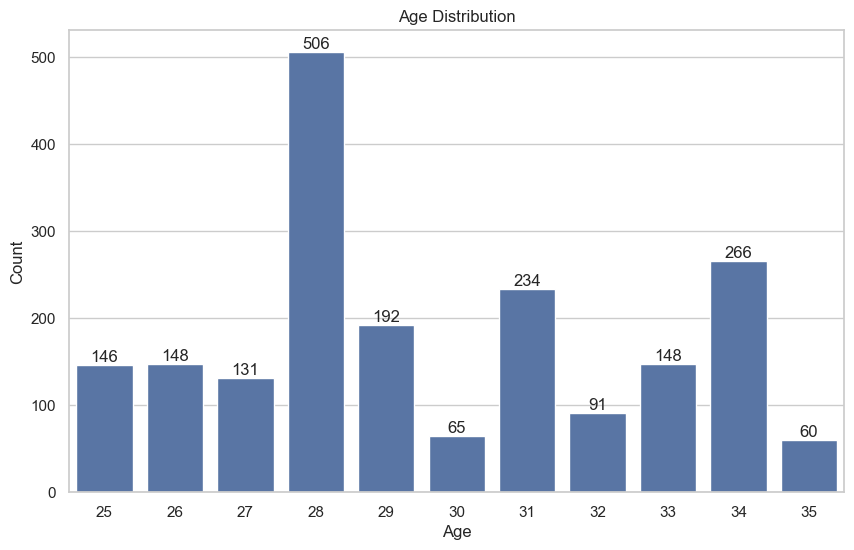

In [22]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="Age")

ax.set_title("Age Distribution")
ax.set_ylabel("Count")
plt.bar_label(ax.containers[0]);

We can see that 28 years old people take big part of our data, also we have small amount of people whose age is 30 and 35. From 25 to 30 we have similar counts of people in dataset with big rise of 28 years old, while in other hand from 30 till 35 we have very uneven data, which goes from 60 to 266 count per age.
Next, let's see how many of these people have been graduated or not.

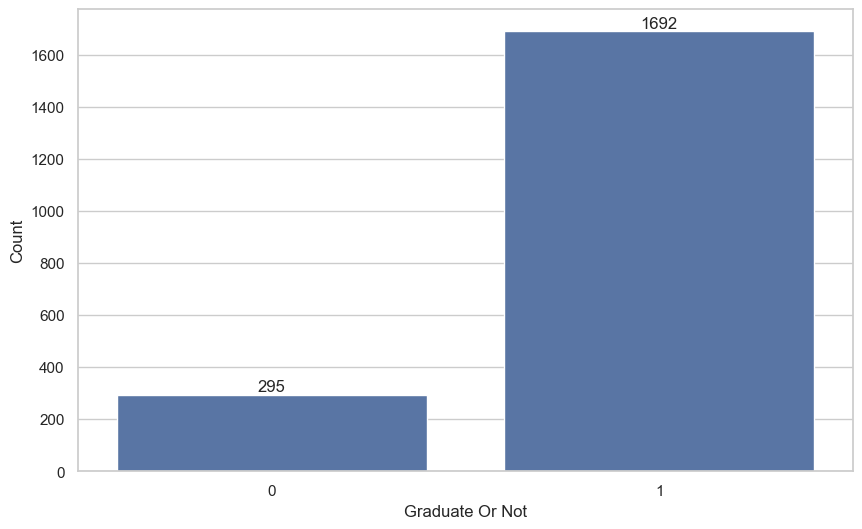

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="Graduate Or Not")
ax.set_ylabel("Count")
plt.bar_label(ax.containers[0]);

<li>295 people not been graduated.</li>
<li>1692 people graduated.</li>

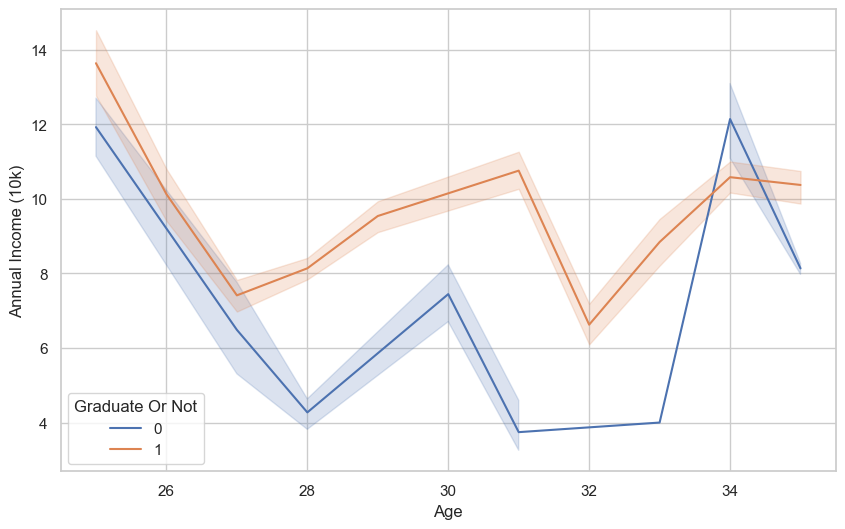

In [24]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x="Age", y="Annual Income (10k)", hue="Graduate Or Not")
plt.show()

<li>Younger people tend to get higher salary.</li>
<li>It is possible that they started the job with higher pay than people who started years ago.</li>
<li>Older people who are 34–35 probably get higher pay due to experience or seniority level.</li>
<li>Graduated people get bigger pay overall.</li>

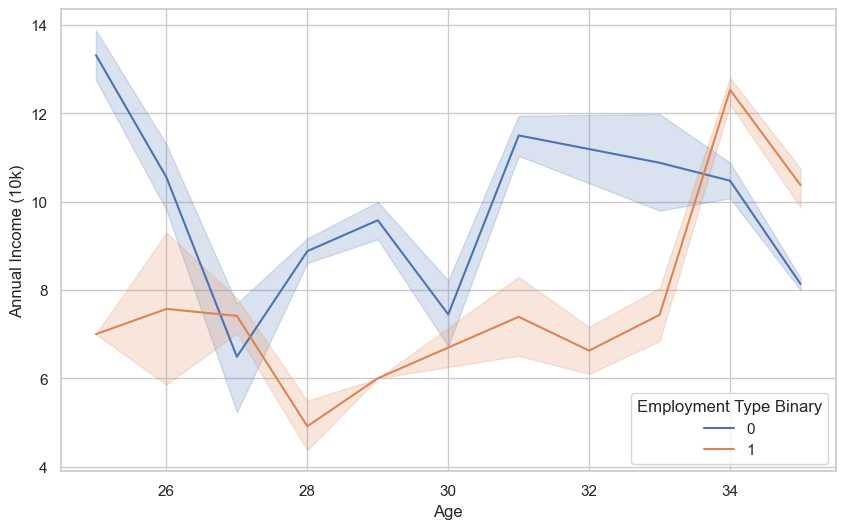

In [25]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df, 
    x="Age", 
    y="Annual Income (10k)", 
    hue="Employment Type Binary");

<li>Government sector - indicates value 1.</li>
<li>Private Sector/Self Employed - indicates value 0.</li>
<li>People working in Government sector earn less than Private Sector/Self Employed.</li>

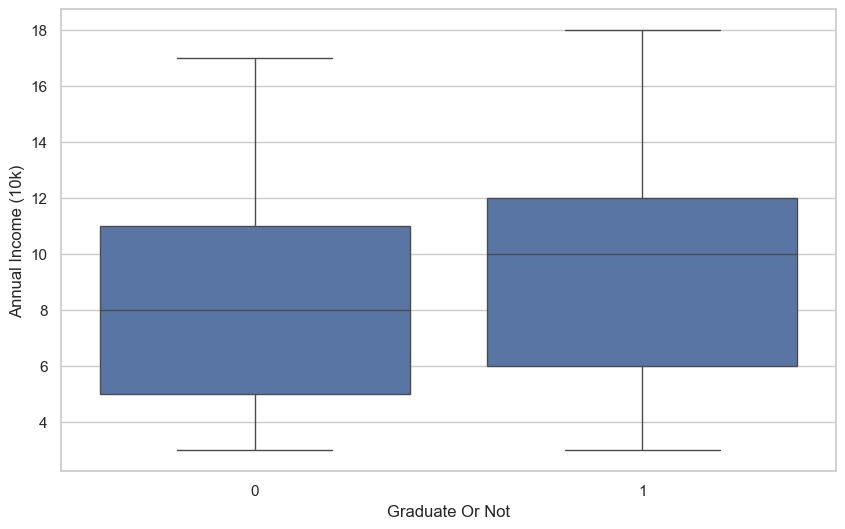

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Graduate Or Not", y="Annual Income (10k)")
plt.show()

<li>Graduated and Not get same the lowest pay, 30000.</li>
<li>Graduated get 10 000 bigger pay at maximum pay.</li>
<li>On average, we see 20 000 pay difference between the two groups.</li>

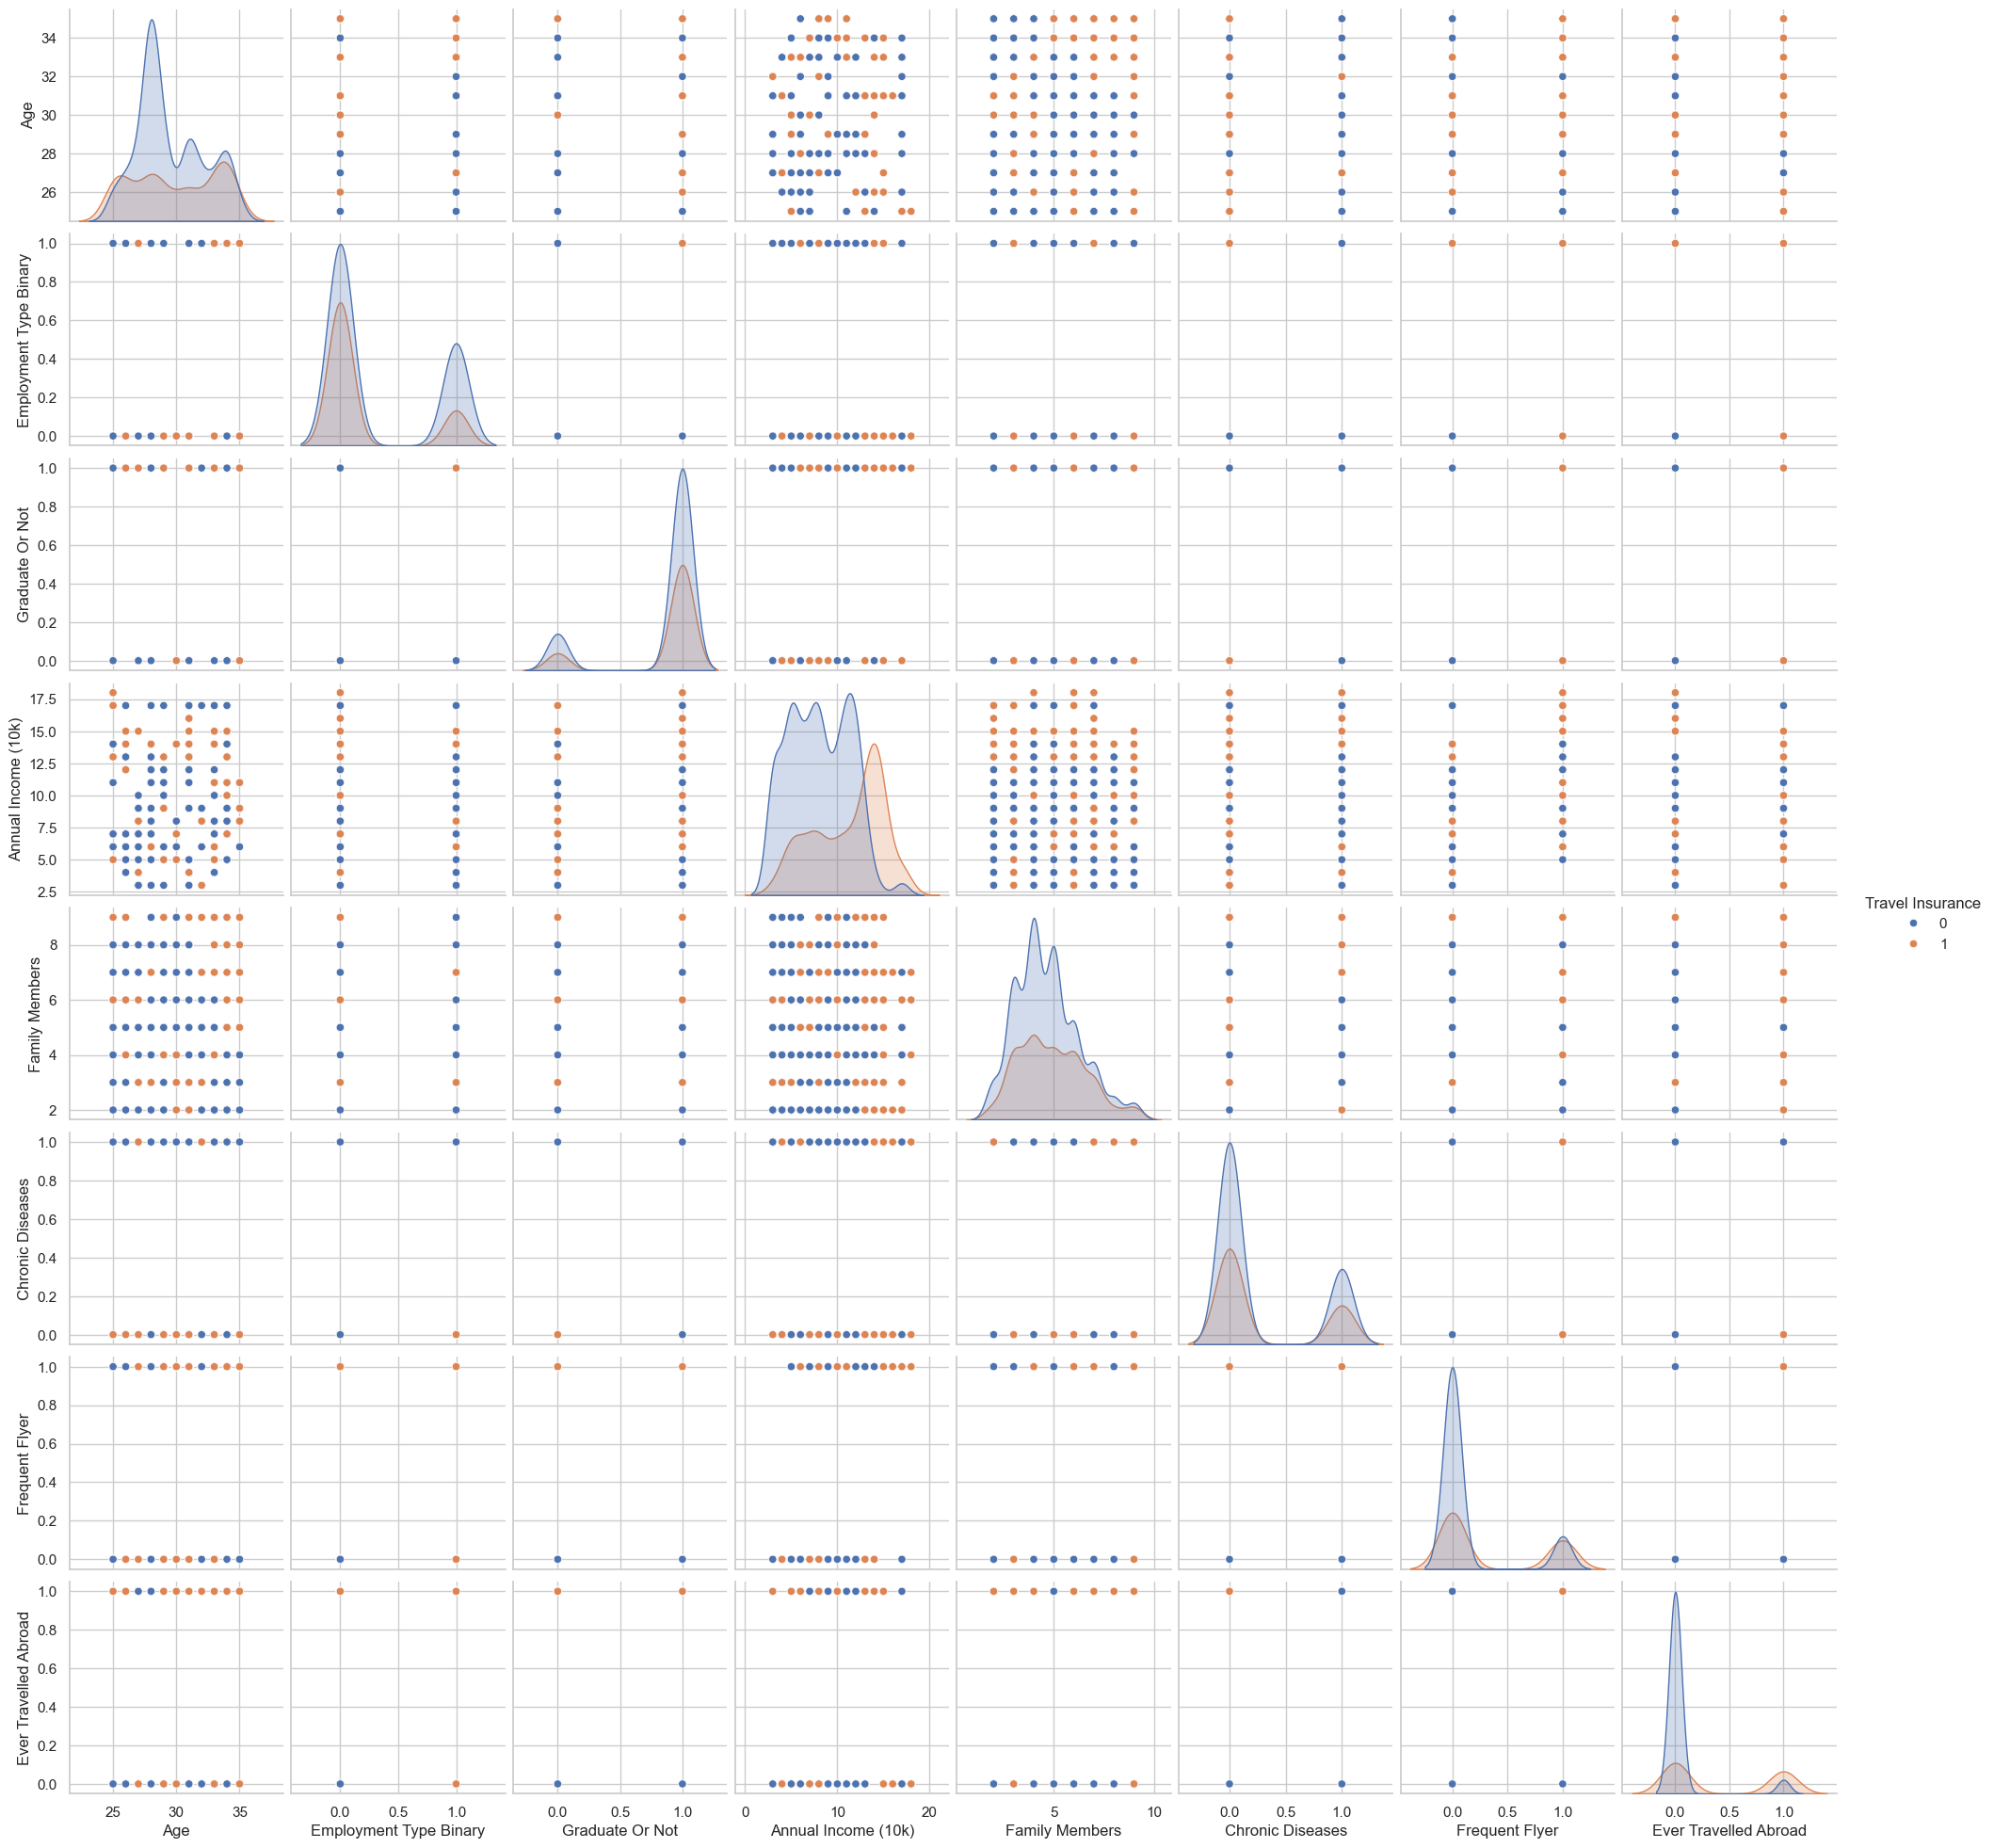

In [27]:
sns.pairplot(df, hue="Travel Insurance")
plt.show()

<li>People who tend to travel more, tend to have Insurance.</li>
<li>Family member number increase per age.</li>
<li>Annual income have impact if customer have Insurance or not.</li>
<li>People with Chronic Diseases tend to have Insurance more often.</li>

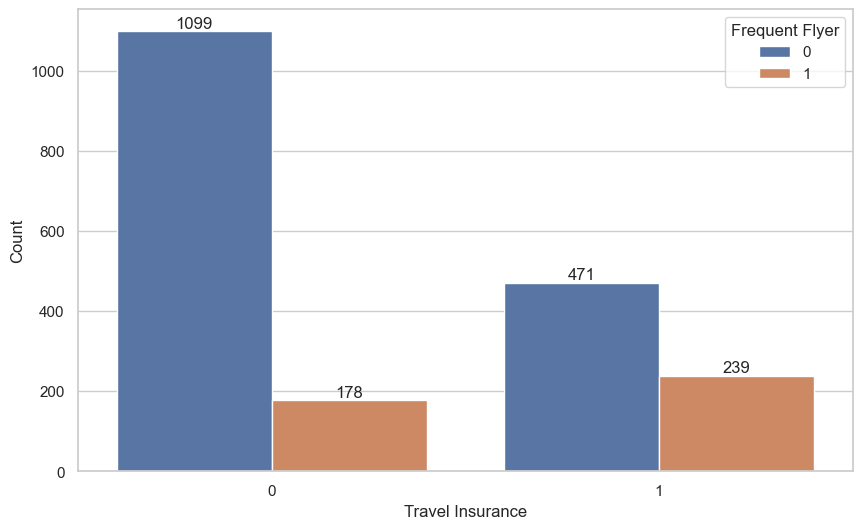

In [28]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df, 
    x="Travel Insurance", 
    hue="Frequent Flyer")

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylabel("Count");

<li>Most of the people in our data take Travel Insurance - 1277 out of 1987, more than half.</li>
<li>178 customers who don't take Insurance also are not Frequent Flyer.</li>
<li>239 who take Insurance are also Frequent Flyer.</li>

### Does Customer Annual Salary have impact for decision of Travel Insurance?

We will use T-test for the means of two independent samples of values to answer this question.

Null Hypothesis (H0): The mean of Annual salary of customers with Travel Insurance is equal to the mean of customers without Travel Insurance.

Alternative Hypothesis (H1): The mean of Annual salary of customers with Travel Insurance is not equal to the mean of customers without Travel Insurance.

We will set a 95% confidence level and check if it rejects the null hypothesis.

The α value is a threshold we will set, by which it says that the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the null hypothesis. Our α = 0.05, so our confidence (1 - α) is 95%.

T-Statistic: 19.41
P-Value: 0.00
Reject the null hypothesis. The observed distribution is significantly different from expected.


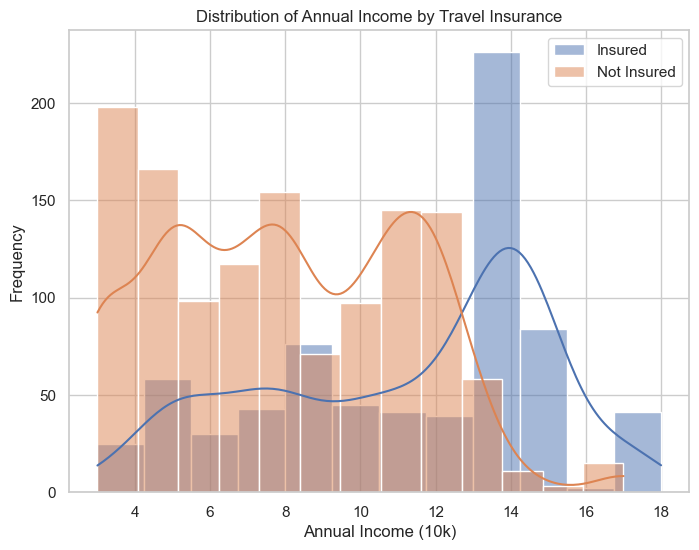

In [29]:
# Set up dataframes
customer_with_insurance = df[df["Travel Insurance"] == 1]["Annual Income (10k)"]
customer_without_insurance = df[df["Travel Insurance"] == 0]["Annual Income (10k)"]

# Perform t-test
t_stats, p_val = ttest_ind(customer_with_insurance, customer_without_insurance)

plt.figure(figsize=(8, 6))
sns.histplot(customer_with_insurance, kde=True, label="Insured")
sns.histplot(customer_without_insurance, kde=True, label="Not Insured")
plt.xlabel('Annual Income (10k)')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income by Travel Insurance')
plt.legend()

print(f"T-Statistic: {t_stats:.2f}")
print(f"P-Value: {p_val:.2f}")

# Check if we reject or fail to reject the null hypothesis
if p_val < 0.05:
    print("Reject the null hypothesis. The observed distribution is significantly different from expected.")
else:
    print("Fail to reject the null hypothesis. The observed distribution is not significantly different from expected.")

## Can we predict if customer takes Travel Insurance?

As we have different features, we will use them to predict if customer takes Travel Insurance using some ML models.

In [30]:
y_results = df["Travel Insurance"]
X = df.iloc[:, :-1]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_results, test_size=0.15, random_state=10, shuffle=True)

In [32]:
regressor_default = LogisticRegression()
regressor_default.fit(X_train, y_train)
y_pred_default = regressor_default.predict(X_test)

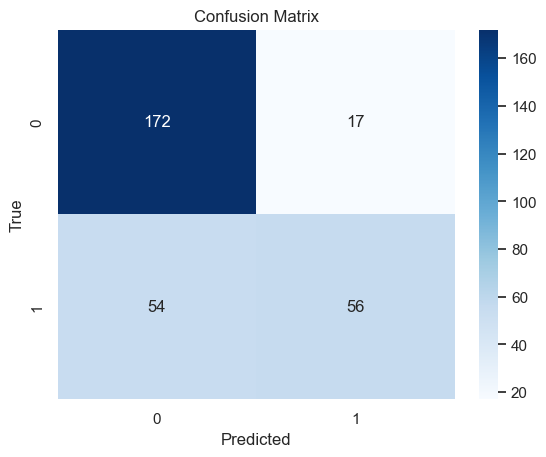

In [33]:
cm = confusion_matrix(y_test, y_pred_default)

sns.heatmap(cm, 
            annot=True, 
            cmap="Blues", 
            fmt=".3g")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix");

In [34]:
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       189
           1       0.77      0.51      0.61       110

    accuracy                           0.76       299
   macro avg       0.76      0.71      0.72       299
weighted avg       0.76      0.76      0.75       299



<li><b>Precision</b> is the ratio of correctly predicted positive observations to the total predicted positives. In this case, 76% of the instances predicted as "0" were actually correct and 77% for "1".</li>
<li><b>Recall</b> is the ratio of correctly predicted positive observations to the all observations in actual class. Here, the model correctly identified 91% of all actual "0" instances and 51% for "1".</li>
<li><b>F1-Score</b> is the harmonic mean of precision and recall. It provides a single metric that balances the two, with 1 being the best and 0 the worst.</li>
<li><b>Support</b> is the number of actual occurrences of the class in the dataset. There are 189 instances where the customer did not take travel insurance and 110 where he take it.</li>

<b>Macro Average</b> - The average for both classes, not taking class imbalance into account.
<b>Weighted Average</b> - The average for both classes, weighted by the number of instances in each class.

We have our baseline, let's adjust some hyperparameter to get better ML model also we include Standard Scales as many models work better if all features have a similar scaling also we will create pipeline.

In [35]:
pipeline = Pipeline(
    steps=[
        ("Preprocessor", StandardScaler()), 
        ("Classifier", LogisticRegression())
    ]
)

We can evaluate the performance of the model using cross-validation.

In [36]:
# Set up parameters
model_solvers = ["liblinear", "lbfgs"]
model_classifier_params = [0.001, 0.01, 0.1, 1, 10]
model_max_iterations = [100, 1000, 10000]
model_tol = [0.0001, 0.001, 0.01]

In [37]:
best_params = {}
best_score = 0
best_score_std = 0

for solver in model_solvers:
    for C in model_classifier_params:
        for max_iter in model_max_iterations:
            for tol in model_tol:
                pipeline.set_params(
                    Classifier__solver=solver, 
                    Classifier__C=C, 
                    Classifier__max_iter=max_iter, 
                    Classifier__tol=tol)
                cv_results = cross_validate(pipeline, X_train, y_train)
                scores = cv_results["test_score"]
                mean_score = scores.mean()
                mean_std = scores.std()

                # Save results
                if mean_score > best_score:
                    best_score = mean_score
                    best_score_std = mean_std
                    best_params = {
                        "Classifier__solver": solver, 
                        "Classifier__C":C, 
                        "Classifier__max_iter":max_iter, 
                        "Classifier__tol":tol}

print(f"The best test set accuracy is {best_score:.3f} +- {best_score_std:.3f}")
print(f"The best parameters found are:\n {best_params}")

The best test set accuracy is 0.771 +- 0.019
The best parameters found are:
 {'Classifier__solver': 'liblinear', 'Classifier__C': 0.01, 'Classifier__max_iter': 100, 'Classifier__tol': 0.0001}


As we get the best parameters for our model, we will use them to check the results.

In [38]:
best_cs = best_params["Classifier__solver"]
best_C = best_params["Classifier__C"]
best_miter = best_params["Classifier__max_iter"]
best_tol = best_params["Classifier__tol"]

regressor_manual = LogisticRegression(solver=best_cs, C=best_C, max_iter=best_miter, tol=best_tol)
regressor_manual.fit(X_train, y_train)
y_pred_manual = regressor_manual.predict(X_test)

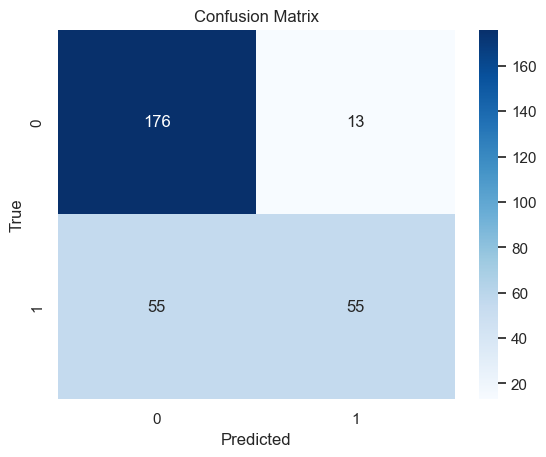

In [39]:
cm = confusion_matrix(y_test, y_pred_manual)

sns.heatmap(cm, 
            annot=True, 
            cmap="Blues", 
            fmt=".3g")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix");

In [40]:
print(classification_report(y_test, y_pred_manual))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       189
           1       0.81      0.50      0.62       110

    accuracy                           0.77       299
   macro avg       0.79      0.72      0.73       299
weighted avg       0.78      0.77      0.76       299



As we can see manual Hyperparameter tuning didn't help us to improve our model. Let's try automatic tuning using randomized-search.

In [41]:
# Define the parameter distribution
param_dist = {
    "Classifier__C": loguniform(0.001, 100),
    "Classifier__solver": ['liblinear', 'lbfgs'],
    "Classifier__max_iter": [100, 200, 500, 1000],
    "Classifier__tol": uniform(1e-4, 1e-2)
}

In [42]:
# Initialize RandomizedSearchCV
model_random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    random_state=10
)

In [43]:
model_random_search.fit(X_train, y_train)

accuracy  = model_random_search.score(X_test, y_test)
print("Test set accuracy:", accuracy)
print("Best parameters:", model_random_search.best_params_)

Test set accuracy: 0.7625418060200669
Best parameters: {'Classifier__C': 0.03755211127922445, 'Classifier__max_iter': 500, 'Classifier__solver': 'liblinear', 'Classifier__tol': 0.0035634715008003304}


In [44]:
y_pred_auto = model_random_search.predict(X_test)

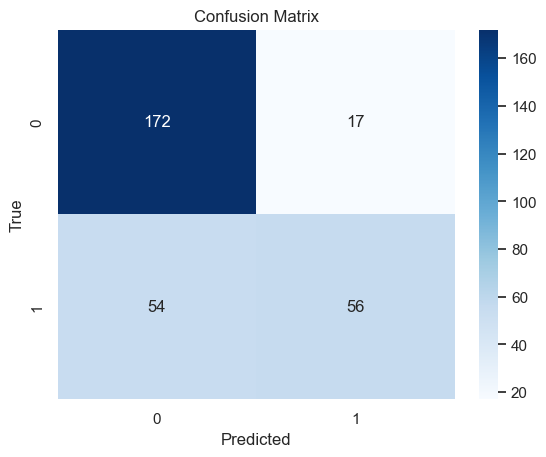

In [45]:
cm = confusion_matrix(y_test, y_pred_auto)

sns.heatmap(cm, 
            annot=True, 
            cmap="Blues", 
            fmt=".3g")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix");

In [46]:
print(classification_report(y_test, y_pred_auto))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       189
           1       0.77      0.51      0.61       110

    accuracy                           0.76       299
   macro avg       0.76      0.71      0.72       299
weighted avg       0.76      0.76      0.75       299



After performing 3 approaches, we can say that all of them give us similar results. Logistic Regression model is one of the basic ones, which can lead to simple results due to complexity of the model. But also as our sample size is quite small and customer count for Taking Insurance and Not is also quite different which can lead to model poor performance, as we see support 189 and 110 for test. 
Overall our all 3 models reach accuracy >75% which is indicates good model.

## Summary

<b>Data Cleaning</b>

<li>Data don't have any duplicate or missing values in our data.</li>
<li>We change columns <b>GraduateOrNot</b>, <b>FrequentFlyer</b> and <b>EverTravelledAbroad</b> types from object to int.</li>
<li>We add additional column <b>Employment Type Binary</b> which corresponds to Employment Type, but it will show numeric values.</li>
<li>Formatted column names.</li>
<li>Modify Annual Income to represent thousands.</li>

<b>Exploratory Data Analysis</b>

<li>We don't find any outliers which can lead to issues.</li>
<li>Income have negative correlation with Employment Type, which means we have big difference between Employment Type and Salary.</li>
<li>Income also have positive correlation with traveling, which is quite obvious.</li>
<li>People tend to get Travel Insurance if they Travel Abroad.</li>
<li>Younger people tend to get higher salary.</li>
<li>It is possible that they started the job with higher pay than people who started years ago.</li>
<li>Older people who are 34–35 probably get higher pay due to experience or seniority level.</li>
<li>Graduated people get bigger pay overall.</li>
<li>Most of the people in our data take Travel Insurance - 1277 out of 1987, more than half.</li>
<li>178 customers who don't take Insurance also are not Frequent Flyer.</li>
<li>239 who take Insurance are also Frequent Flyer.</li>
<li>The mean of Annual salary of customers with Travel Insurance is not equal to the mean of customers without Travel Insurance.</li>

<b>Travel Insurance predictions</b>

<li>Created 3 different approaches for the Logistic Regression model.</li>
<li>Default one give same results as automatic hyperparameter tuning with randomized-search.</li>
<li>Best results with manual editing: Classifier__solver: 'liblinear', Classifier__C: 0.01, Classifier__max_iter: 100, Classifier__tol: 0.0001. </li>


## Recommendations

<li>Customer with higher salary tend to have Travel Insurance more often than customers with lower salary, they should be marketing priority.</li>
<li>Customers who travel often tend to order Travel Insurance, to save these customers discounts could help.</li>
<li>Customers with lower income could also get some discounts to rise they number.</li>

## Suggestion For Improvement

<li>Try different ML models and adjust their configuration to find better fit.</li>
<li>Perform feature engineering to reduce feature number and correlation, which can lead to better results.</li>